This jupyter notebook contains the code for the module 4 project of building a recommendation system. It imports two datasets from https://grouplens.org/datasets/movielens/latest/ (ml-latest-small.zip: movies.csv and ratings.csv), one containing movieID, title and genres, and the other containing movieID, rating, userID and timestamp. These datasets were filtered down by userId and the data was visualized using bar graphs and boxplots. The recommendation models was built using surpise, a scipy toolkit which builds and analyzes recommendation systems using explicit rating data. Five models were built - 4 derived from the nearest neighbor approach, and 1 using matrix factorization and SVD, singular value decomposition. The top performing model, according to MAE, was then used to create movie recommendations for a new user, once they input 5 ratings for previously seen movies.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [2]:
# importing csv and converting to data frame
# contains movieId, title, and genres ()
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
print('Shape of movies_df: ', movies_df.shape)
print('Unique movieId values: ', movies_df['movieId'].nunique())

Shape of movies_df:  (9742, 3)
Unique movieId values:  9742


In [4]:
# importing csv and converting to data frame

ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# dropping timestamp colummn

ratings_df = ratings_df.drop('timestamp', axis = 1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
print('Shape of ratings_df: ', ratings_df.shape)
print('Unique movieId values: ', ratings_df['movieId'].nunique())
print('Unique userId values: ', ratings_df['userId'].nunique())

Shape of ratings_df:  (100836, 3)
Unique movieId values:  9724
Unique userId values:  610


In [7]:
# setting index for upcoming join

ratings_df = ratings_df.set_index('movieId')
ratings_df.head()

,userId,rating
movieId,,
1,1,4.0
3,1,4.0
6,1,4.0
47,1,5.0
50,1,5.0


Create two functions for exploratory data analysis: one for seaborn boxplots, one for seaborn barplots. 

In [8]:
def single_boxplot_function(boxplot_data, xlabel_title):
    """This function will create a single boxplot with 2 inputs: data and x axis label"""
    plt.figure(figsize=(12,6))
    sns.boxplot(boxplot_data, palette = 'husl')
    plt.xticks(fontsize = 14)
    plt.xlabel(xlabel_title, fontsize = 18)
    plt.tight_layout()

In [9]:
def bar_graph_function(x_list, y_list, title_title, xlabel_title, ylabel_title):
    """This function will create a bar plot with 5 inputs: 
    x axis data, y axis data, plot title, x axis label, y axis label"""
    plt.figure(figsize=(10,8))
    sns.barplot(x = x_list, y = y_list, palette = 'husl')
    plt.title(title_title, fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 14, horizontalalignment="right")
    plt.xlabel(xlabel_title, fontsize = 18)
    plt.yticks(fontsize = 14)
    plt.ylabel(ylabel_title, fontsize = 18)
    plt.tight_layout()

            rating
count   610.000000
mean    165.304918
std     269.480584
min      20.000000
25%      35.000000
50%      70.500000
75%     168.000000
max    2698.000000
Help on function single_boxplot_function in module __main__:

single_boxplot_function(boxplot_data, xlabel_title)
    This function will create a single boxplot with 2 inputs: data and x axis label



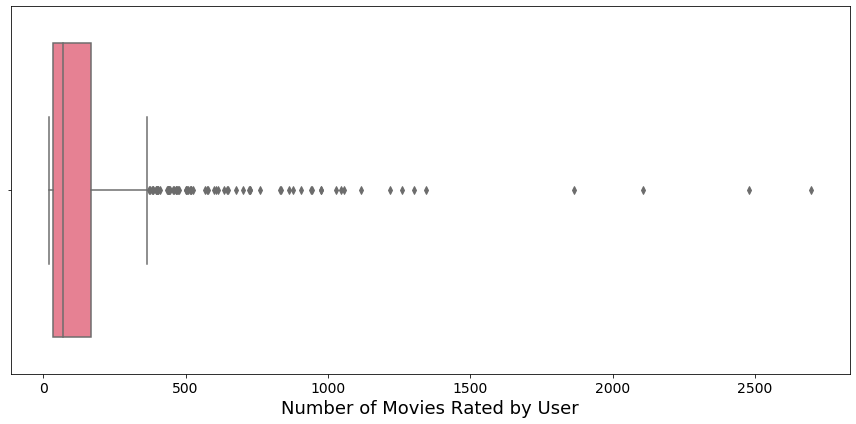

In [10]:
# boxplot of number of reviews per user

num_of_ratings_per_user = pd.DataFrame(ratings_df.groupby('userId')['rating'].count() \
                                       .sort_values(ascending = False))
print(num_of_ratings_per_user.describe())

help(single_boxplot_function)
single_boxplot_function(num_of_ratings_per_user, 'Number of Movies Rated by User')

           rating
count  459.000000
mean    63.657952
std     40.856370
min     20.000000
25%     31.000000
50%     50.000000
75%     89.000000
max    168.000000


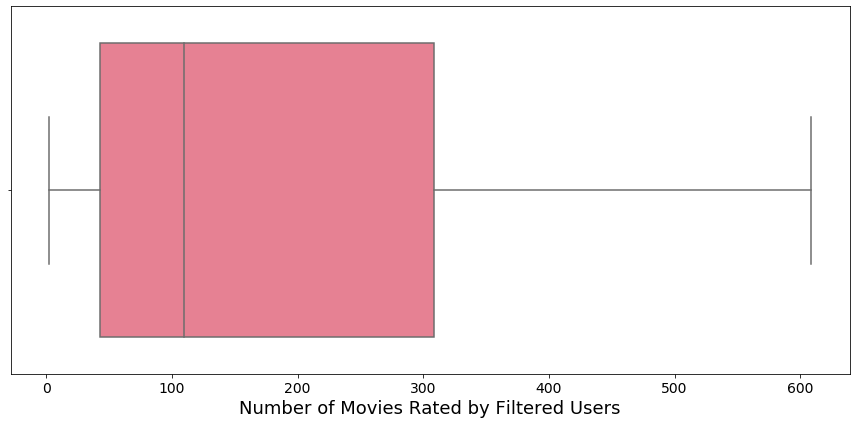

In [11]:
# filtering the users by number of movies rated

filtered_users_by_num_ratings = num_of_ratings_per_user.loc[num_of_ratings_per_user['rating'] \
                                                            < 170]
print(filtered_users_by_num_ratings.describe())
filtered_users_by_num_ratings.reset_index(inplace = True)
filtered_users_by_num_ratings_list = list(filtered_users_by_num_ratings['userId'])

single_boxplot_function(filtered_users_by_num_ratings, 'Number of Movies Rated by Filtered Users')

           rating
count  459.000000
mean     3.696785
std      0.480421
min      1.275000
25%      3.377976
50%      3.753623
75%      4.025893
max      5.000000


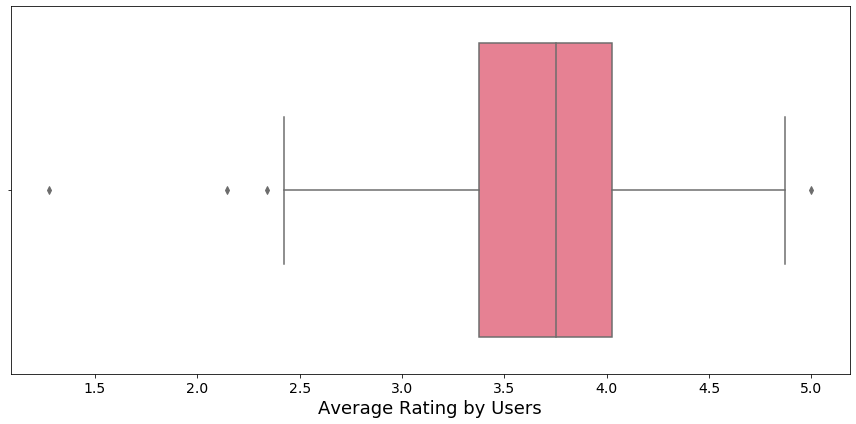

In [12]:
ratings_by_filtered_users = ratings_df.loc[ratings_df['userId']. \
                                           isin(filtered_users_by_num_ratings_list)]
avg_ratings_by_filtered_users = pd.DataFrame(ratings_by_filtered_users. \
                                             groupby('userId')['rating'].mean())
print(avg_ratings_by_filtered_users.describe())

single_boxplot_function(avg_ratings_by_filtered_users, 'Average Rating by Users')

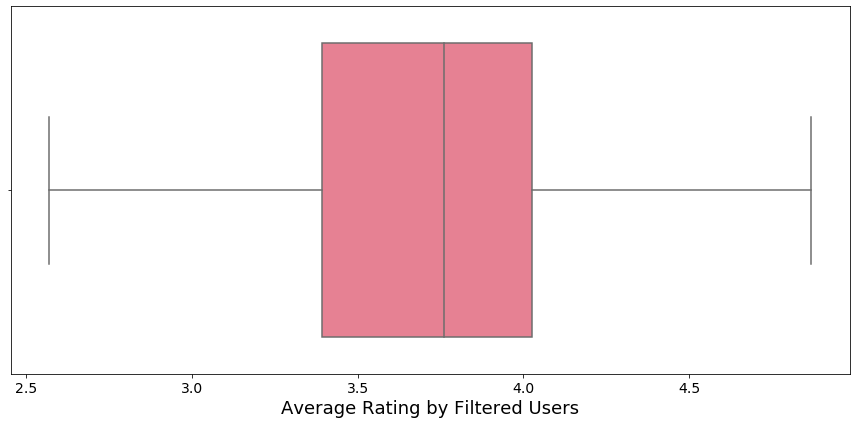

In [13]:
final_users = avg_ratings_by_filtered_users.loc[(avg_ratings_by_filtered_users['rating']>2.45) \
                                                & (avg_ratings_by_filtered_users['rating']<4.9)]

single_boxplot_function(final_users, 'Average Rating by Filtered Users')

In [14]:
# filtering the original ratings_df to only contain filtered users list

final_users.reset_index(inplace = True)
final_users_list = list(final_users['userId'])
final_ratings = ratings_df.loc[ratings_df['userId'].isin(final_users_list)]
print(final_ratings.info())
final_ratings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28973 entries, 318 to 1161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   userId  28973 non-null  int64  
 1   rating  28973 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 679.1 KB
None


,userId,rating
movieId,,
318,2,3.0
333,2,4.0
1704,2,4.5
3578,2,4.0
6874,2,4.0


In [15]:
# resetting index to prepare for a join

movies_df.set_index('movieId', inplace = True)
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB
None


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [16]:
# joining movie name dataframe with genre labels to ratings dataframe on movieId column

movie_ratings = final_ratings.join(movies_df)
print(movie_ratings.info())
movie_ratings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28973 entries, 1 to 193609
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   userId  28973 non-null  int64  
 1   rating  28973 non-null  float64
 2   title   28973 non-null  object 
 3   genres  28973 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB
None


,userId,rating,title,genres
movieId,,,,
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,27,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Help on function bar_graph_function in module __main__:

bar_graph_function(x_list, y_list, title_title, xlabel_title, ylabel_title)
    This function will create a bar plot with 5 inputs: 
    x axis data, y axis data, plot title, x axis label, y axis label



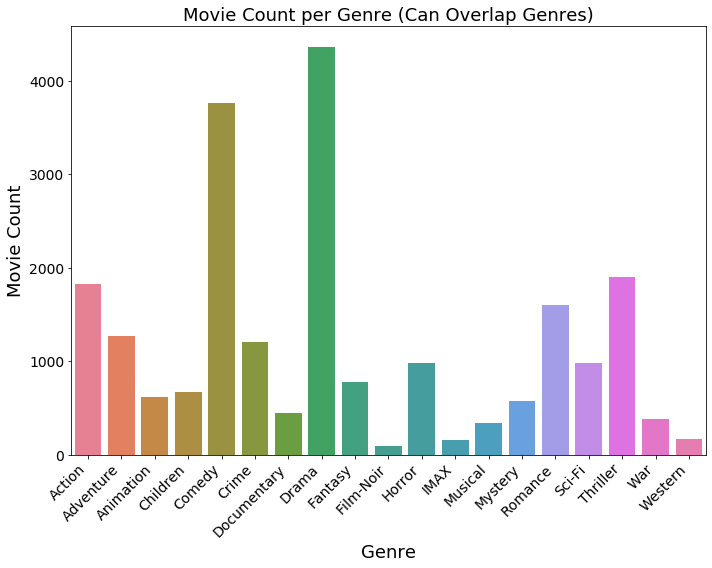

In [17]:
# splitting genres string to seperate columns and 
# plotting number of movies by genre (one movie can overlap genres)

genres_series = movies_df['genres'].str.split('|')
mlb = MultiLabelBinarizer()
genres_ohe = pd.DataFrame(mlb.fit_transform(genres_series),
                   columns=mlb.classes_,
                   index=genres_series.index)
genres_ohe = genres_ohe.drop('(no genres listed)', axis = 1)
genre_count = list(genres_ohe.sum())
genre_list = list(genres_ohe.columns.values)

help(bar_graph_function)
bar_graph_function(genre_list, genre_count, 'Movie Count per Genre (Can Overlap Genres)', \
                   'Genre', 'Movie Count')
plt.savefig('images/movie_count_per_genre.png')

In [18]:
# print(movie_ratings.info())
movie_ratings.head()

,userId,rating,title,genres
movieId,,,,
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,27,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [19]:
# print(genres_ohe.info())
genres_ohe.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# joining genre columns to movie data frame and dropping genre string column
# setting index for upcoming join

movies = movie_ratings.join(genres_ohe)
movies = movies.drop('genres', axis = 1)
movies.reset_index(inplace = True)
# print(movies.info())
movies.head()

,movieId,userId,rating,title,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,5,4.0,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,4.5,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,15,2.5,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,17,4.5,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,27,3.0,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


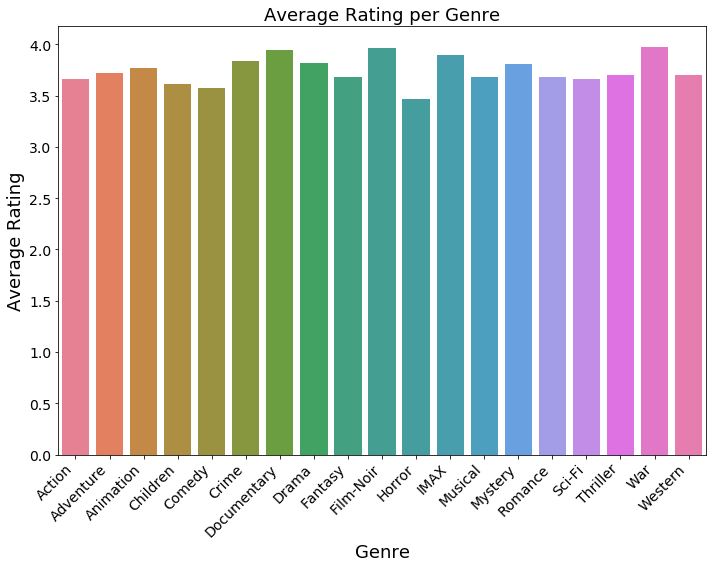

In [21]:
rating_list = []

for each_genre in genre_list: 
    avg_movie_rating_by_genre = movies.loc[movies[each_genre] == 1, 'rating'].mean()
    rating_list.append(avg_movie_rating_by_genre)
    
bar_graph_function(genre_list, rating_list, 'Average Rating per Genre', \
                   'Genre', 'Average Rating')
plt.savefig('images/average_rating_per_genre.png')

In [22]:
# war_check = movies.loc[movies['Action'] == 1, 'rating']
# print(war_check.describe())
# sns.boxplot(war_check, palette = 'husl')

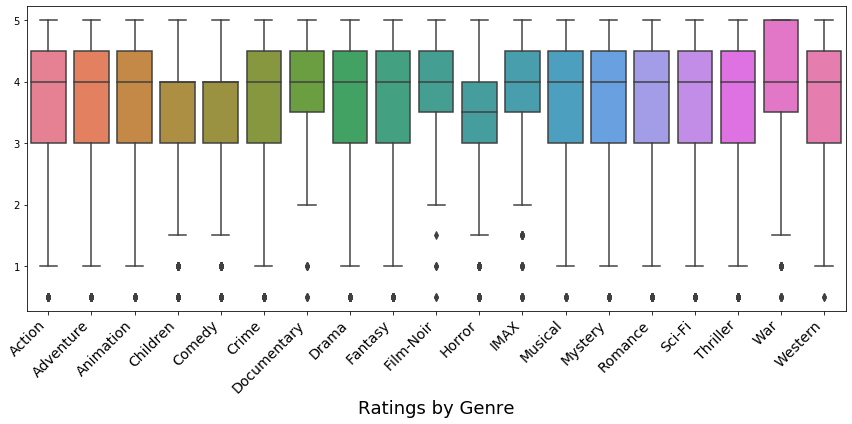

In [23]:
genre_rating_list_master = []

for each_genre in genre_list: 
    list_of_ratings_by_genre = list(movies.loc[movies[each_genre] == 1, 'rating'])
    genre_rating_list_master.append(list_of_ratings_by_genre)
    

plt.figure(figsize=(12,6))
sns.boxplot(data = genre_rating_list_master, palette = 'husl')
plt.xticks(np.arange(len(genre_list)), fontsize = 14, labels = tuple(genre_list), \
           rotation = 45, horizontalalignment="right")
plt.xlabel('Ratings by Genre', fontsize = 18)
plt.tight_layout()
plt.savefig('images/ratings_boxplot_by_genre.png')

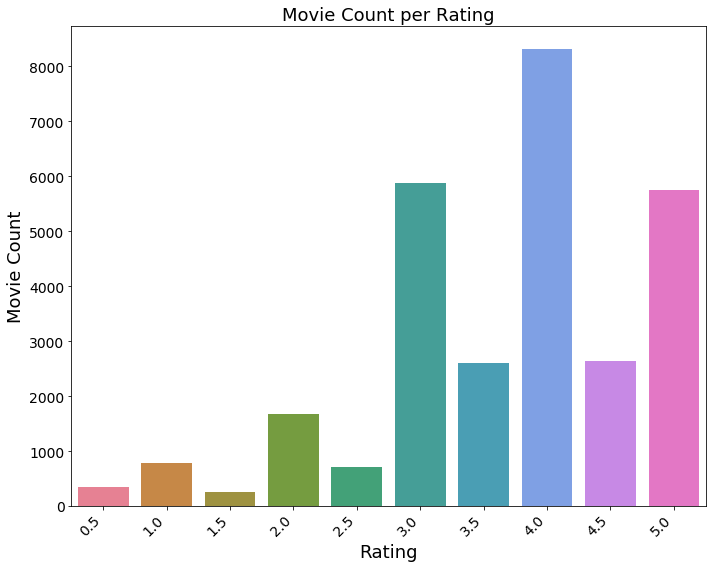

In [24]:
movie_ratings.reset_index(inplace = True)
movie_rating_counts = pd.DataFrame(movie_ratings.groupby('rating')['movieId'].count())
movie_rating_counts.reset_index(inplace = True)

movie_rating_count_lists = list(movie_rating_counts['rating'])
movie_rating_list = list(movie_rating_counts['movieId'])

bar_graph_function(movie_rating_count_lists, movie_rating_list, 'Movie Count per Rating', \
                   'Rating', 'Movie Count')
plt.savefig('images/movie_count_per_rating.png')

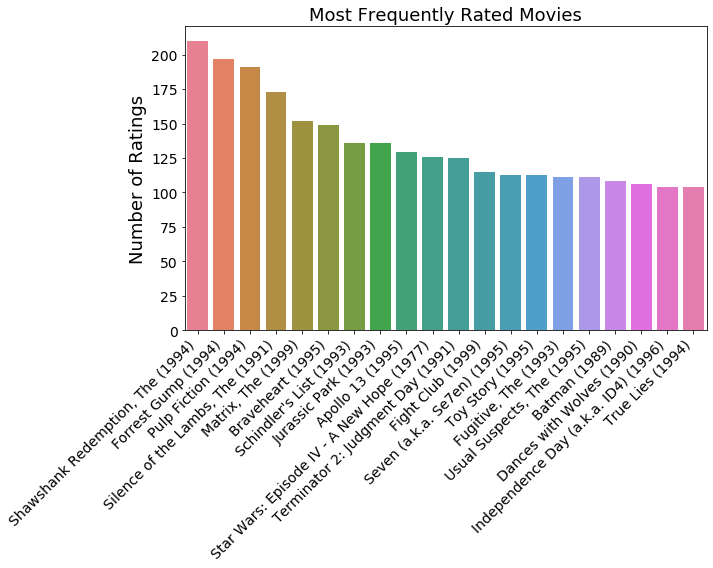

In [25]:
movie_most_ratings = pd.DataFrame(movie_ratings.groupby('title')['movieId']. \
                                  count().sort_values(ascending = False))
most_freq_rated_movies = movie_most_ratings.head(20)
most_freq_rated_movies.reset_index(inplace = True)

most_freq_rated_movies_list = list(most_freq_rated_movies['title'])
how_often_rated_list = list(most_freq_rated_movies['movieId'])

bar_graph_function(most_freq_rated_movies_list, how_often_rated_list, \
                   'Most Frequently Rated Movies', '', 'Number of Ratings')
plt.savefig('images/most_frequently_rated_movies.png')

In [26]:
final_ratings.reset_index(inplace = True)

In [27]:
# need to flip columns in final_ratings df
print(final_ratings.head())
final_ratings = final_ratings[['userId', 'movieId', 'rating']]
print(final_ratings['userId'].nunique())
print(final_ratings['movieId'].nunique())
print(final_ratings.info())
final_ratings.head()

   movieId  userId  rating
0      318       2     3.0
1      333       2     4.0
2     1704       2     4.5
3     3578       2     4.0
4     6874       2     4.0
453
4252
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28973 entries, 0 to 28972
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   28973 non-null  int64  
 1   movieId  28973 non-null  int64  
 2   rating   28973 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 679.2 KB
None


,userId,movieId,rating
0,2,318,3.0
1,2,333,4.0
2,2,1704,4.5
3,2,3578,4.0
4,2,6874,4.0


In [28]:
# transform the dataset into something compatible with surprise
# look at how many users and items we have in our dataset

reader = Reader()
data = Dataset.load_from_df(final_ratings, reader)
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  453 

Number of items:  4252


## Collaborative Filtering for Recommendation Systems:

Surpise, a python library, will be used to analyze different collaborative filtering algorithms for creating a recommendation system. The following algorithms will be created and evaluated

### memory based/neighborhood based collaborative filtering: 

Memory based, or neighborhood based, collaborative filtering algorithms quantify how similar users or items are to one another. These algorithms measure similarity between users or items, by different "similarity metrics". User vs items based, and pearson, pearson-baseline, cosine and MSD similarity metrics, will all be tested within the parameter grids, for each algorithm. The following neighborhood-based collaborative filtering methods will be tested:

https://surprise.readthedocs.io/en/stable/knn_inspired.html

    KNNBasic: A basic collaborative filtering algorithm
    KNNBaseline: A basic collaborative filtering algorithm taking into account a baseline rating.
    KNNWithMeans: A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
    KNNWithZScore: A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

Each of the algorithms will have the following parameter grid:

https://surprise.readthedocs.io/en/stable/similarities.html
    
    k: The max number of neighbors to take into account for aggregation
    min_k: The minimum number of neighbors to take into account for aggregation

    Item-based: measure the similarity between the items that target users rates/interacts with and other items
    vs.
    User-based: measure the similarity between target users and other users 

    Similarity metrics:
        pearson: Calculate Pearson correlation coefficients between all user (or item) pairs
        vs.
        cosine: Calculate cosine similarity between all user (or item) pairs
        vs.
        MSD: Calculates the mean squared difference between similarity between all users (or item) pairs 
        vs. 
        pearson_baseline: Calculates shrunk Pearson correlation coefficient between all user (or item) pairs

### model based collaborative filtering: 

Another way to make recommendation systems is by using model based collaborative filtering. Model based filtering can make predictions by viewing the dataset as a matrix, and by decomposing that matrix into individual matrices. This reduction of dimensionality can be completed using Singular-Value Decomposition or SVD. With SVD, the recommendation problem is turned into an optimization problem that deals with how good we are in predicting the rating for items given a user. The optimization is completed by minimizing the squared error using gradient descent. 

https://surprise.readthedocs.io/en/stable/matrix_factorization.html

Alternating least squares is another matrix decomposition method, but it is best used when there are missing values in the matrix. Because our dataset does not contain missing values, we will stick to SVD for matrix decomposition.  

Parameter grid for SVD:

    n_epochs: the number of iterations of SGD, which is basically an iterative method used in Statistics to minimize a function.
    lr_all: the learning rate for all parameters, which is a parameter that decides how much the parameters are adjusted in each iteration.
    reg_all: the regularization term for all parameters, which is a penalty term added to prevent overfitting.
    
Scoring:

    Mean Absolute Error (MAE): computes the deviation between predicted ratings and actual ratings

    Root Mean Square Error (RMSE): similar to MAE, but places more emphasis on larger deviation (punishes gross inaccuracies)

In [29]:
knnbasic = KNNBasic
knnbaseline = KNNBaseline
knnwithmeans = KNNWithMeans
knnwithzscore = KNNWithZScore
svd = SVD
filtering_scores = {}

# optimized KNN gridsearch

# knn_grid = {'k': [30, 40, 50, 60],
#             'min_k': [5, 10, 15],
#             'sim_options': {'name': ['cosine', 'pearson', 'MSD', 'pearson_baseline'], \
#                             'user_based': [True, False]},
#             'random_state': [123]}

# KNN gridsearch with best_params

knn_grid = {'k': [40],
            'min_k': [10],
            'sim_options': {'name': ['cosine', 'pearson', 'MSD', 'pearson_baseline'], \
                            'user_based': [True, False]},
            'random_state': [123]}


# optimized SVD gridsearch

# svd_grid = {'reg_all': [0.05, 0.15, 0.25],
#             'n_epochs':[50, 70, 90, 110],
#             'lr_all': [0.05, 0.01, 0.015], 
#             'random_state': [123]}

# SVD gridsearch with best_params

svd_grid = {'reg_all': [0.15],
            'n_epochs':[70],
            'lr_all': [0.01], 
            'random_state': [123]}

def g_s_function(filtering_option, param_grid, data_set):
    """This function will take in 3 inputs: collaborative filtering method, 
    parameter grid, and dataset. It will then perform a gridsearch using 
    cross validation to create an optimal prediction model. The model will 
    then be scored using RMSE and MAE, and will return the scores with the 
    optimal parameters."""

    g_s_filtering_option = GridSearchCV(filtering_option, param_grid = param_grid, n_jobs=-1)
    g_s_filtering_option.fit(data_set)
    print(filtering_option)
    print(g_s_filtering_option.best_score)
    print(g_s_filtering_option.best_params)
    return (g_s_filtering_option.best_score, g_s_filtering_option.best_params)

In [30]:
filtering_scores['knnbasic'] = g_s_function(knnbasic, knn_grid, data)  
filtering_scores['knnbaseline'] = g_s_function(knnbaseline, knn_grid, data)    
filtering_scores['knnwithmeans'] = g_s_function(knnwithmeans, knn_grid, data) 
filtering_scores['knnwithzscore'] = g_s_function(knnwithzscore, knn_grid, data)    
filtering_scores['svd'] = g_s_function(svd, svd_grid, data)    

<class 'surprise.prediction_algorithms.knns.KNNBasic'>
{'rmse': 0.964080213277755, 'mae': 0.7364634469380426}
{'rmse': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'MSD', 'user_based': False}, 'random_state': 123}, 'mae': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'MSD', 'user_based': False}, 'random_state': 123}}
<class 'surprise.prediction_algorithms.knns.KNNBaseline'>
{'rmse': 0.9168729444645433, 'mae': 0.6968941835901586}
{'rmse': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}, 'mae': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 123}}
<class 'surprise.prediction_algorithms.knns.KNNWithMeans'>
{'rmse': 0.948411385977872, 'mae': 0.720261977842218}
{'rmse': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'MSD', 'user_based': True}, 'random_state': 123}, 'mae': {'k': 40, 'min_k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'random_stat

The KNNBaseline performed the best according to the MAE score. The MAE score was chosen for comparing models because it is a more intuitive score - with a MAE score of 0.7, that means that the models predicted rating is on average, +/- 0.7 stars off of the actual rating. KNNBaseline will now be used to create recommendations for a new user, who will input 5 movie ratings to overcome the cold start problem. KNNBaseline will also be used to predict a rating for an existing user, for a movie they have not seen yet. 

In [31]:
movies_df.reset_index(inplace = True)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
# narrowing down the top 500 most frequently rated movies for new user ratings

hundred_movie_most_ratings = pd.DataFrame(movie_ratings.groupby('movieId')['title'].count() \
                                          .sort_values(ascending = False))
hundred_most_freq_rated_movies = hundred_movie_most_ratings.head(500)
hundred_most_freq_rated_movies.reset_index(inplace = True)
hundred_most_freq_rated_movies_list = list(hundred_most_freq_rated_movies['movieId'])
top_500_freq_rated_movies_df = movies_df.loc[movies_df['movieId']. \
                                             isin(hundred_most_freq_rated_movies_list)]
top_500_freq_rated_movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller


In [33]:
# getting ratings for 5 movies from new user

def movie_rater(movie_dataset,num, genre=None):
    """This function will ask the (new) user for ratings of 5 different movies 
    to address the cold start problem. The movies are coming from a list of the 
    top 500 most frequently rated movies. The user can press n if the have not 
    seen the movie, or if it has already been rated."""
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_dataset[movie_dataset['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_dataset.sample(1)
        print(movie)
        rating = input("""How do you rate this movie on a scale of 1-5?
        Press n if you have not seen or already rated:""")
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID, 'movieId':movie['movieId'].values[0], \
                                'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list  

user_rating = movie_rater(top_500_freq_rated_movies_df, 5)

      movieId                title                               genres
4360     6377  Finding Nemo (2003)  Adventure|Animation|Children|Comedy
How do you rate this movie on a scale of 1-5?
        Press n if you have not seen or already rated:5
     movieId                            title                       genres
307      349  Clear and Present Danger (1994)  Action|Crime|Drama|Thriller
How do you rate this movie on a scale of 1-5?
        Press n if you have not seen or already rated:n
     movieId                              title                 genres
138      165  Die Hard: With a Vengeance (1995)  Action|Crime|Thriller
How do you rate this movie on a scale of 1-5?
        Press n if you have not seen or already rated:n
      movieId                                  title  \
1997     2657  Rocky Horror Picture Show, The (1975)   

                            genres  
1997  Comedy|Horror|Musical|Sci-Fi  
How do you rate this movie on a scale of 1-5?
        Press n if you ha

In [34]:
# add the new user ratings to the original ratings DataFrame

new_ratings_df = final_ratings.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

# train a model using the new combined DataFrame

baseline = KNNBaseline(sim_options={'name': 'MSD', 'user_based': False})
baseline.fit(new_data.build_full_trainset())

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [35]:
# make predictions for the new user and put into list

list_of_movies = []
for m_id in final_ratings['movieId'].unique():
    list_of_movies.append( (m_id,baseline.predict(1000,m_id)[3]))

# order the predictions from highest to lowest rated

ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [36]:
# format and print list of recommendations for new user
list_of_recommended_movies = []

def recommended_movies(user_ratings,movie_title_df,n):
    """This function will print out the top 5 recommended movies for the new user."""
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        list_of_recommended_movies.append(title)
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies,movies_df,5)

Recommendation #  1 :  8509    The Drop (2014)
Name: title, dtype: object 

Recommendation #  2 :  8828    The Jinx: The Life and Deaths of Robert Durst ...
Name: title, dtype: object 

Recommendation #  3 :  1527    Parent Trap, The (1998)
Name: title, dtype: object 

Recommendation #  4 :  7845    21 Jump Street (2012)
Name: title, dtype: object 

Recommendation #  5 :  790    Fox and the Hound, The (1981)
Name: title, dtype: object 



In [37]:
# make recommendations for existing users (movies_df and final_ratings)
# pick a userID

final_ratings.head()
users_list = final_ratings['userId'].unique()
movies_list =  final_ratings['movieId'].unique()
users_list[:10]

array([ 2,  5,  7,  8,  9, 10, 11, 12, 13, 14])

In [38]:
# find a movie that user 2 has not seen yet (in movies_list, but not user_2_movies_list)

user_2_movies = final_ratings.loc[final_ratings['userId'] == 2, ['movieId']]
user_2_movies_list = user_2_movies['movieId']
movies_user_2_has_not_rated = np.setdiff1d(movies_list, user_2_movies_list)
movies_user_2_has_not_rated[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [39]:
# find the title of the chosen movie

movies_id_1 = movies_df.loc[movies_df['movieId'] ==1]
movies_id_1

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [40]:
# make the prediction for the users rating
user_2_movie_1_prediction = baseline.predict(2,1)
round(user_2_movie_1_prediction[3], 2)

4.04